In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
cd "OneDrive - Vodafone Group/Desktop/Nanodegree/Nanodegree final prj"


C:\Users\rpaglin\OneDrive - Vodafone Group\Desktop\Nanodegree\Nanodegree final prj


In [3]:
cd "AI_startercode/"

C:\Users\rpaglin\OneDrive - Vodafone Group\Desktop\Nanodegree\Nanodegree final prj\AI_startercode


<b>Loading dataframe containing robot execution data:

The dataframe include data from execution of maze navigation over 240 different mazes in 8 different robot configuration (to be compared in this notebook). As there is some random choice in maze navigation, each maze/configuration pair was tested 10 times, for a total of 240 x 8 x 10 = 19200 executions 

In [4]:
df=pd.read_csv('validrandommaze\\RobotEvaluationDataTest.csv')

In [5]:
df.head()

,Unnamed: 0,MazeName,MazeSize,MazeAttempt,MazeNPossibleWalls,MazeNWalls,MazeShortestPath,RobotExpMode,RobotIteration,RobotRun0Moves,RobotRun1Moves,RobotRun0Known,RobotRun1Known,RobotKnownWalls,RobotPercWallsDisc,RobotPercMazeDiscRun0,RobotScore
0,0,.\validrandommaze\ran_12_120_155621.txt,12,120,312,168,13,0,0,77,14,190,191,118,0.702381,0.608974,16.566667
1,1,.\validrandommaze\ran_12_120_155621.txt,12,120,312,168,13,0,1,33,84,123,224,132,0.785714,0.394231,85.100000
2,2,.\validrandommaze\ran_12_120_155621.txt,12,120,312,168,13,0,2,30,80,122,214,126,0.750000,0.391026,81.000000
3,3,.\validrandommaze\ran_12_120_155621.txt,12,120,312,168,13,0,3,31,84,122,224,132,0.785714,0.391026,85.033333
4,4,.\validrandommaze\ran_12_120_155621.txt,12,120,312,168,13,0,4,54,55,149,220,131,0.779762,0.477564,56.800000


In [6]:
df.columns

Index(['Unnamed: 0', 'MazeName', 'MazeSize', 'MazeAttempt',
       'MazeNPossibleWalls', 'MazeNWalls', 'MazeShortestPath', 'RobotExpMode',
       'RobotIteration', 'RobotRun0Moves', 'RobotRun1Moves', 'RobotRun0Known',
       'RobotRun1Known', 'RobotKnownWalls', 'RobotPercWallsDisc',
       'RobotPercMazeDiscRun0', 'RobotScore'],
      dtype='object')

In [7]:
df['MazeName'].nunique() #Expected 240

240

In [8]:
df['RobotExpMode'].nunique() #Expected 8

8

In [9]:
len(df.MazeName) #Expected 19200

19200

<b>Maze Analysis<b>

Let's first have a look at the mazes we created; to this task, we isolate maze info in a dedicated dataset

In [10]:
mazes=df[(df.RobotIteration==0) & (df.RobotExpMode==0) ][['MazeName', 'MazeSize', 'MazeAttempt',
       'MazeNPossibleWalls', 'MazeNWalls', 'MazeShortestPath']]

In [11]:
mazes['WallDensity']=mazes.MazeNWalls/mazes.MazeNPossibleWalls

MazeAttempt parameter is the threshold used in the maze generation algorithm to give up in the attempt to add a wall. Once this threshold is reached the maze was considered completed. We used 4 different MazeAttempt values in the maze generation 

In [12]:
sorted(mazes.MazeAttempt.unique())

[5, 20, 60, 120]

We expect that the number of walls and in turn maze density increases for higher values of MazeAteempt. Let's see:

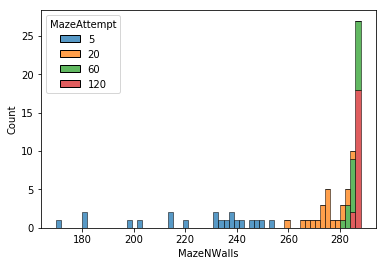

In [13]:
sns.histplot(mazes[mazes.MazeSize==16],x='MazeNWalls',hue='MazeAttempt',palette="tab10",multiple="stack",bins=60)
#sns.histplot(mazes[mazes.MazeSize==16],x='MazeNWalls',hue='MazeAttempt',palette="tab10",element="poly")

We can also argue that an increased number of walls correspond to a longer shortest path.  

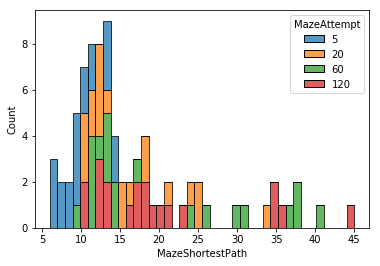

In [14]:
sns.histplot(mazes[mazes.MazeSize==16],x='MazeShortestPath',hue='MazeAttempt',palette="tab10",multiple="stack",bins=40)
#sns.histplot(mazes[mazes.MazeSize==16],x='MazeShortestPath',hue='MazeAttempt',palette="tab10",element='poly')

In [15]:
mazes.groupby([ 'MazeSize', 'MazeAttempt']).mean()

MazeNPossibleWalls  MazeNWalls  MazeShortestPath  \
MazeSize MazeAttempt                                                     
12       5                         312.0      135.25              9.55   
         20                        312.0      163.35             15.40   
         60                        312.0      167.10             14.05   
         120                       312.0      167.95             15.10   
14       5                         420.0      171.35             10.60   
         20                        420.0      216.30             12.75   
         60                        420.0      222.60             16.30   
         120                       420.0      223.60             16.25   
16       5                         544.0      223.45              9.65   
         20                        544.0      275.15             16.20   
         60                        544.0      285.70             20.70   
         120                       544.0      287.55             20.10   

                      WallDensity  
MazeSize MazeAttempt               
12       5               0.433494  
         20              0.523558  
         60              0.535577  
         120             0.538301  
14       5               0.407976  
         20              0.515000  
         60              0.530000  
         120             0.532381  
16       5               0.410754  
         20              0.505790  
         60              0.525184  
         120             0.528585

<b> Finding best exploring path

Now we address a different target, that is comparing performance of different exploring options defined for Run 0.
Options are define below, where:
'br'= bottom right
'bl= bottom left
'tr'= top right
'tl'= top left
'cc' = maze center box (4 cells)


In [16]:
exploring_paths = {0:[],
                   1:[['br','tl','tr']],
                   2:[['bl']],
                   3:[['br','tl','tr'],['bl']],
                   4:[['tl'],['cc'],['tr'],['cc'],['br'],['cc']],
                   5:[['bl'],['cc'],['bl'],['cc']],
                   6:[['bl'],['cc'],['bl'],['cc'],['bl'],['cc']],
                   7: [['tl'], ['tr'], ['br'], ['bl']]}

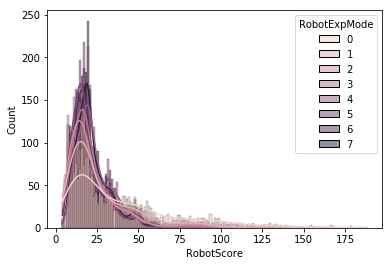

In [17]:
sns.histplot(df,x='RobotScore',hue='RobotExpMode',kde=True)

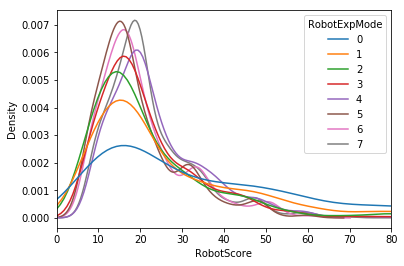

In [18]:
sns.kdeplot(data=df,x='RobotScore',hue='RobotExpMode',palette="tab10",fill=False)
plt.xlim(0, 80)
plt.show()

In [19]:
overall_mean=df.groupby('RobotExpMode').mean()['RobotScore']

In [20]:
overall_mean.index=['0','1','2','3','4','5','6','7']

In [21]:
overall_mean=overall_mean.sort_values(ascending=False)

Text(0.5,1,'Comparizon among exp model - All mazes')

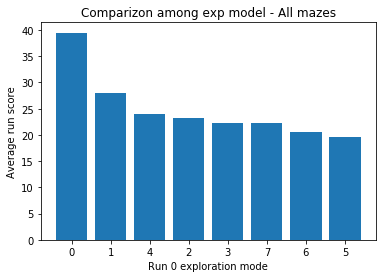

In [22]:
plt.bar(overall_mean.index, overall_mean)
plt.ylabel('Average run score')
plt.xlabel('Run 0 exploration mode')
plt.title('Comparizon among exp model - All mazes')

The graphs above clearly show some better performance on exploration_path[5], that is requesting the robot to loop between bottom left and center 3 times before moving to run 1

Now let's see if there is any dependency on maze size or maze complexity: 

In [23]:
mean_x_mazesize=df.groupby(['MazeSize','RobotExpMode']).mean()['RobotScore'].reset_index()

In [24]:
mean_x_mazesize.head(5)

,MazeSize,RobotExpMode,RobotScore
0,12,0,33.702125
1,12,1,23.032875
2,12,2,20.685000
3,12,3,19.911875
4,12,4,20.509000


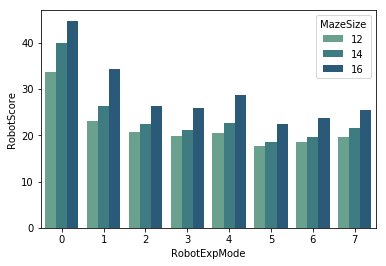

In [25]:
sns.barplot( data=mean_x_mazesize, x='RobotExpMode', y='RobotScore',hue='MazeSize',palette="crest")

In [26]:
#function minimum_path(n) return the minimum number of moves from a corner to the center on an empty maze of size nxn boxes, 
#given that each  move can be up to 'max_step' boxes 
max_step=3
def minimum_path(n):   
    m=int(np.ceil((n/2-1)/max_step)*2)
    return(m)


Let's define maze complexity as the ratio between the shortest path on the maze and the shortest path of an empty maze with same size

In [27]:
df['MazeComplexity']=df.MazeShortestPath/(df.MazeSize.apply(minimum_path))

In [28]:
print(df.MazeComplexity.min(), df.MazeComplexity.mean(),df.MazeComplexity.max())

1.0 3.217361111111101 9.75


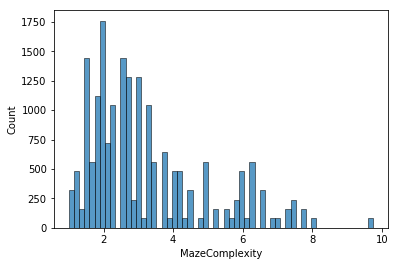

In [29]:
sns.histplot(df,x='MazeComplexity')

In [30]:
#we define threshold for low, medium and high complexity, trying to have three similarly sized set
df['MazeComplexityLab']='Low'
df.loc[(df.MazeComplexity>2.),'MazeComplexityLab']='Medium'
df.loc[(df.MazeComplexity>3.5),'MazeComplexityLab']='High'

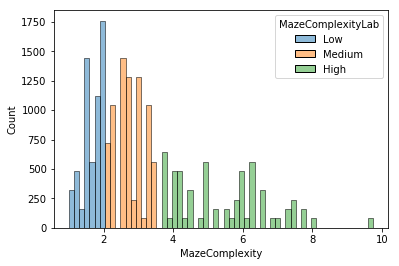

In [31]:
sns.histplot(df,x='MazeComplexity',hue='MazeComplexityLab', hue_order=['Low','Medium','High'], palette="tab10")

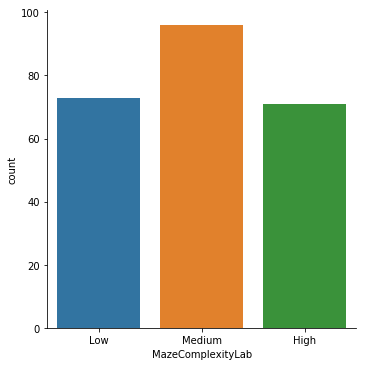

In [32]:
sns.catplot(data=df[(df.RobotIteration==0) & (df.RobotExpMode==0)], kind="count",x='MazeComplexityLab', order=['Low','Medium','High'],palette="tab10")

In [33]:
mean_x_mazecomplexity=df.groupby(['MazeComplexityLab','RobotExpMode']).mean()['RobotScore'].reset_index()

In [34]:
mean_x_mazecomplexity.head(5)

,MazeComplexityLab,RobotExpMode,RobotScore
0,High,0,53.664178
1,High,1,43.408920
2,High,2,33.116150
3,High,3,32.313803
4,High,4,35.963568


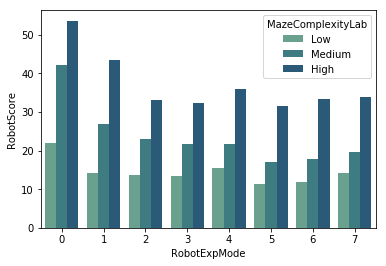

In [35]:
sns.barplot( data=mean_x_mazecomplexity, x='RobotExpMode', y='RobotScore',hue='MazeComplexityLab',palette="crest",hue_order=['Low','Medium','High'])

<b>Mode 5 appears to be the best choice!

Results obtianed on exploration mode 5 are better than in other modes, regardless of maze size and on the introduced measure of maze complexity 

Let's concentrate now on results obtained in mode 5:

In [36]:
df5=df[df.RobotExpMode==5]

In [37]:
df5.RobotIteration.count() #240 x 10 = 2400 rows expected

2400

<b> What makes a  maze 'complex' for the robot? <b>

The set of mazes used in this analysis was randomly generated, with a few the constraints:
- n x n size, with N= 12,14 or 16
- closed perimetral wall
- center box composed of 4 squares, with only one exit
- bottom left box with only exit in the 'up' direction

In order to explore the complexity of different mazes for our algorithm, we measure:

- 'Run1Effectiveness': the ratio between the average algorithm performance (in run 1) and the number of moves needed on the shortest path (between bottom left to center) on the same maze,  and

- 'ScoreEffectiveness': the ratio between the final score obtained and the number of moves needed on the shortest path 


In [38]:
OnShortPath=df5[df5.MazeShortestPath==df5.RobotRun1Moves].RobotIteration.count()
print('Number of Run where run1 was on shortest path: {}'.format(OnShortPath)) 
print('Number of Run1 on longer path: {}'.format(df5.RobotIteration.count()-OnShortPath)) 

Number of Run where run1 was on shortest path: 2310
Number of Run1 on longer path: 90


In [39]:
df5['Run1Effectiveness']=df5.RobotRun1Moves/df5.MazeShortestPath
df5['ScoreEffectiveness']=df5.RobotScore/df5.MazeShortestPath

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Start search for difficult mazes, using Run1Effectiveness as an indicator

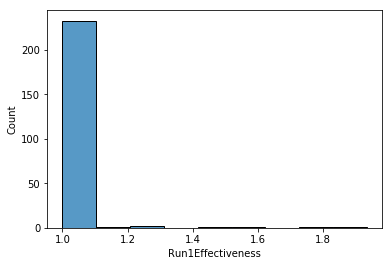

In [40]:
df5means=df5.groupby('MazeName').mean().reset_index()
sns.histplot(df5means.Run1Effectiveness)

Let's limit the search to those attempts where run1 didn't manage to find the shortest path:

In [41]:
df5means[df5means.Run1Effectiveness>1.0].MazeName.count()

45

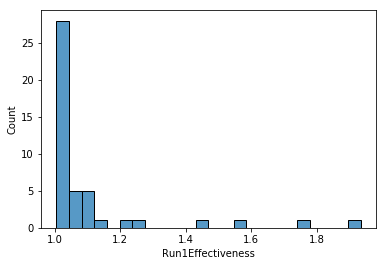

In [42]:
sns.histplot(df5means[df5means.Run1Effectiveness >1].Run1Effectiveness)

We have 6 mazes with worst average performance. Let's find names:

In [43]:
difficult_mazes=df5means[df5means.Run1Effectiveness>1.15].MazeName.unique()
df5means[df5means.MazeName.isin(difficult_mazes)][['MazeName','Run1Effectiveness']].sort_values(['Run1Effectiveness'],ascending=False)

,MazeName,Run1Effectiveness
138,.\validrandommaze\ran_14_5_177437.txt,1.933333
8,.\validrandommaze\ran_12_120_157616.txt,1.750000
136,.\validrandommaze\ran_14_5_176343.txt,1.583333
218,.\validrandommaze\ran_16_5_177757.txt,1.450000
202,.\validrandommaze\ran_16_5_157637.txt,1.255556
65,.\validrandommaze\ran_12_60_161577.txt,1.210000


Now, lets's see if looking at score effectiveness we find anything different (remember that score effectiveness is based on score, so it also counts number of moves on run 0

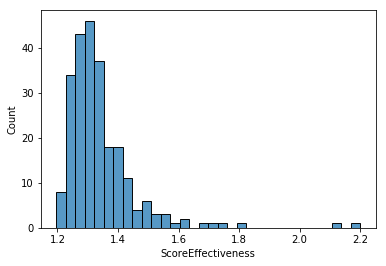

In [44]:
sns.histplot(df5means.ScoreEffectiveness)

search for difficult mazes is repeated, now using ScoreEffectiveness as an indicator

In [45]:
difficult_mazes_score=df5means[df5means.ScoreEffectiveness>1.6].MazeName.unique()
df5means[df5means.MazeName.isin(difficult_mazes_score)][['MazeName','ScoreEffectiveness']].sort_values(['ScoreEffectiveness'],ascending=False)

,MazeName,ScoreEffectiveness
138,.\validrandommaze\ran_14_5_177437.txt,2.201111
8,.\validrandommaze\ran_12_120_157616.txt,2.118611
136,.\validrandommaze\ran_14_5_176343.txt,1.805556
99,.\validrandommaze\ran_14_120_176375.txt,1.752083
173,.\validrandommaze\ran_16_120_162374.txt,1.713077
218,.\validrandommaze\ran_16_5_177757.txt,1.681667
65,.\validrandommaze\ran_12_60_161577.txt,1.633333
233,.\validrandommaze\ran_16_60_162361.txt,1.619286


Worst three mazes are the same for score and run1 effectiveness and Worst case maze is 'ran_14_5_177437.txt'.

This maze is selected for indeep analysis in the project write up. Its performance are saved in a csv file

In [46]:
df_diff=df5[(df5.MazeName=='.\\validrandommaze\\ran_14_5_177437.txt') ]
df_diff.to_csv('difficult_maze.csv')
df_diff

,Unnamed: 0,MazeName,MazeSize,MazeAttempt,MazeNPossibleWalls,MazeNWalls,MazeShortestPath,RobotExpMode,RobotIteration,RobotRun0Moves,...,RobotRun0Known,RobotRun1Known,RobotKnownWalls,RobotPercWallsDisc,RobotPercMazeDiscRun0,RobotScore,MazeComplexity,MazeComplexityLab,Run1Effectiveness,ScoreEffectiveness
11090,11090,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,0,47,...,145,145,87,0.502890,0.345238,7.566667,1.5,Low,1.000000,1.261111
11091,11091,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,1,67,...,220,225,113,0.653179,0.523810,8.233333,1.5,Low,1.000000,1.372222
11092,11092,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,2,62,...,194,199,107,0.618497,0.461905,8.066667,1.5,Low,1.000000,1.344444
11093,11093,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,3,47,...,145,145,87,0.502890,0.345238,7.566667,1.5,Low,1.000000,1.261111
11094,11094,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,4,39,...,107,138,87,0.502890,0.254762,15.300000,1.5,Low,2.333333,2.550000
11095,11095,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,5,39,...,116,202,109,0.630058,0.276190,31.300000,1.5,Low,5.000000,5.216667
11096,11096,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,6,39,...,107,138,87,0.502890,0.254762,15.300000,1.5,Low,2.333333,2.550000
11097,11097,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,7,38,...,114,139,85,0.491329,0.271429,15.266667,1.5,Low,2.333333,2.544444
11098,11098,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,8,39,...,107,138,87,0.502890,0.254762,15.300000,1.5,Low,2.333333,2.550000
11099,11099,.\validrandommaze\ran_14_5_177437.txt,14,5,420,173,6,5,9,65,...,207,212,110,0.635838,0.492857,8.166667,1.5,Low,1.000000,1.361111


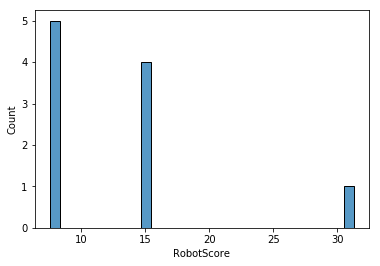

In [47]:
sns.histplot(df_diff.RobotScore, bins=30)

In [48]:
df_diff.MazeShortestPath.unique()

array([6], dtype=int64)

In [49]:
df_diff[['RobotScore', 'Run1Effectiveness','ScoreEffectiveness', 'RobotRun0Moves', 'RobotRun1Moves']].sort_values('RobotScore')

,RobotScore,Run1Effectiveness,ScoreEffectiveness,RobotRun0Moves,RobotRun1Moves
11090,7.566667,1.000000,1.261111,47,6
11093,7.566667,1.000000,1.261111,47,6
11092,8.066667,1.000000,1.344444,62,6
11099,8.166667,1.000000,1.361111,65,6
11091,8.233333,1.000000,1.372222,67,6
11097,15.266667,2.333333,2.544444,38,14
11094,15.300000,2.333333,2.550000,39,14
11096,15.300000,2.333333,2.550000,39,14
11098,15.300000,2.333333,2.550000,39,14
11095,31.300000,5.000000,5.216667,39,30


As visible from figures above, behavior of the robot can be divided into two sets. In the first 5 rows:
- Robot spent an average of about 57 moves in run 0
- Run 1 was on shortest path (run1 effectiveness = 1) 
- Score was about 8 points

For the remaining half of the runs:
- Robot spent 38 or 39 moves in run 0
- Run 1 took more than twice the shortest path (up to 5 time the shortest path in one run)  
- Score ranging from 15 to 30 ponts

The explanation of this behavior required an additional dedicated analysis, running the robot again for a set of runs and this time tracking the path taken. The oucome is discussed in detail in project write up